#  Plot NREL 2.8-127 Performance curve for AMR-Wind+OpenFAST

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

%matplotlib inline

# Important header information
amrwindfedir = '/projects/wind_uq/lcheung/amrwind-frontend/'  # where amrwind-frontend resides
import sys, os
sys.path.insert(1, amrwindfedir)
import OpenFASTutil as OpenFAST

In [2]:
# Define some helper functions

def avgoutputs(pddat, tavg, keys, timekey='Time'):
    """
    Function to average the pddat over a specific time
    """
    t = pddat[timekey].values
    
    # Filter the appropriate times
    timefilter = (tavg[0]<=t)&(t<=tavg[1])
    tfilter   = t[timefilter]
    # Get the total time
    dt = np.amax(tfilter) - np.amin(tfilter)

    outdict = {}
    for key in keys:
        #f = pddat[key].values
        outdict[key] = np.trapz(pddat[key].values[timefilter], x=tfilter, axis=0) / dt
    return outdict

readoutfile = lambda f: pd.read_csv(f,sep='\s+',skiprows=(0,1,2,3,4,5,7), header=(0),skipinitialspace=True)

def calcCt(p,  rho, U, rmax, ctkey='RtAeroFxh'):
    thrust = p[ctkey]
    A = np.pi*rmax*rmax
    Q = 0.5*rho*U*U*A
    Ct = thrust/Q
    return Ct

# Grep a file for a pattern
def grepfile(filename, pattern):
    file = open(filename, "r")
    for line in file:
        if line.startswith(pattern):
            return line
    return None

In [3]:
# Global averaging parameters
tavg = [300, 360]
avgq = ['GenPwr', 'RotSpeed', 'BldPitch1', 'RotTorq','RtAeroCt','RtAeroFxh']
#avgq = ['GenPwr', 'RotSpeed', 'BldPitch1', 'GenTq','RotTorq','RtAeroCt']
pcvar= ['generator power [kW]', 'rotor speed [RPM]', 'blade pitch [deg]', 
        'rotor torque [kN-m]','Ct [-]', 'rotor thrust [kN]']
rho  = 1.0
rmax = 127.0/2

In [4]:
# Load AMR-Wind OpenFAST data

# Change this directory to wherever the cases were run
amrdir = '/nscratch/lcheung/2021/AWAKEN/turbinerun/GE2.8-127' 
PC_amr = [] #OrderedDict()

PC_amr.append({'tag':'AMRWind ADM $\epsilon$=3 N=64',
                'WS':9.0,
                'outfile':amrdir+'/AMRWIND_ADM_NREL2p8_WS9.0/turbine0_OpenFAST_NREL2p8-127/NREL-2p8-127.out',
                'rho':1.0,
                'color':'c',
                'mfc':'c',
                'ms':'s'})

PC_amr.append({'tag':'',
                'WS':7.0,
                'outfile':amrdir+'/AMRWIND_ADM_NREL2p8_WS7.0/turbine0_OpenFAST_NREL2p8-127/NREL-2p8-127.out',
                'rho':1.0,
                'color':'c',
                'mfc':'c',
                'ms':'s'})

PC_amr.append({'tag':'',
                'WS':11.0,
                'outfile':amrdir+'/AMRWIND_ADM_NREL2p8_WS11.0/turbine0_OpenFAST_NREL2p8-127/NREL-2p8-127.out',
                'rho':1.0,
                'color':'c',
                'mfc':'c',
                'ms':'s'})


for pc in PC_amr:
    datafile = pc['outfile']
    print(datafile)
    # For ascii output:
    outdat   = readoutfile(datafile)
    pc.update(avgoutputs(outdat, tavg, avgq))

/nscratch/lcheung/2021/AWAKEN/turbinerun/GE2.8-127/AMRWIND_ADM_NREL2p8_WS9.0/turbine0_OpenFAST_NREL2p8-127/NREL-2p8-127.out
/nscratch/lcheung/2021/AWAKEN/turbinerun/GE2.8-127/AMRWIND_ADM_NREL2p8_WS7.0/turbine0_OpenFAST_NREL2p8-127/NREL-2p8-127.out
/nscratch/lcheung/2021/AWAKEN/turbinerun/GE2.8-127/AMRWIND_ADM_NREL2p8_WS11.0/turbine0_OpenFAST_NREL2p8-127/NREL-2p8-127.out


In [5]:
# Get original design power curve
# Note that this file is available at https://github.com/NREL/openfast-turbine-models/tree/master/IEA-scaled/NREL-2.8-127
pc = pd.read_csv('NREL-2.8-127.csv')

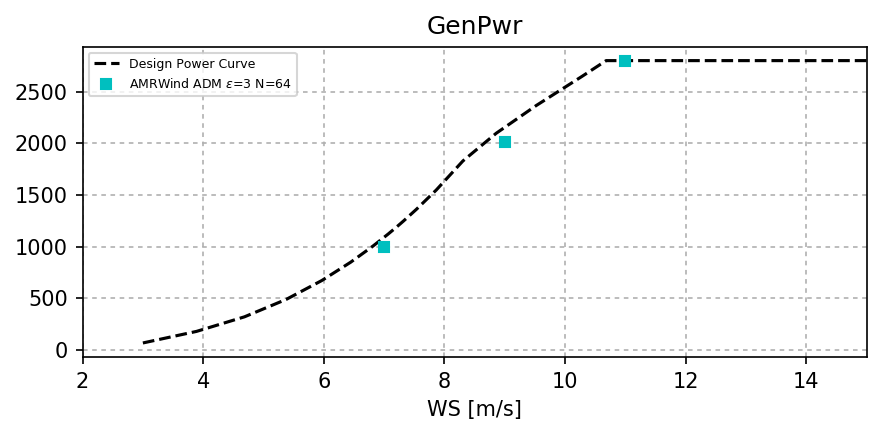

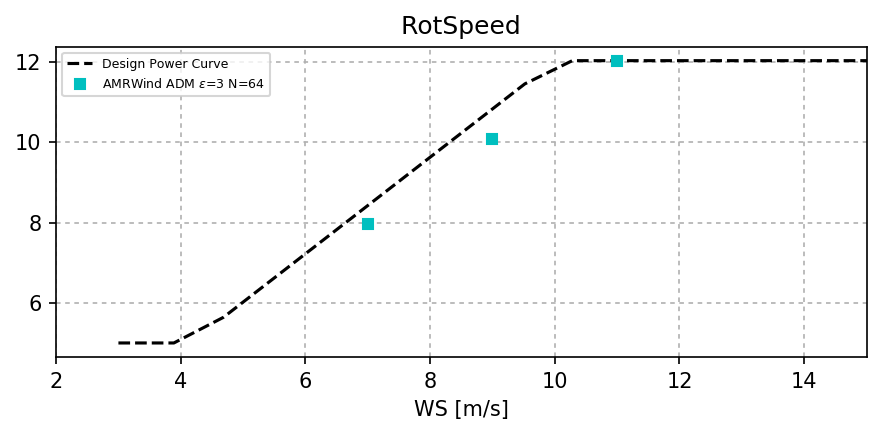

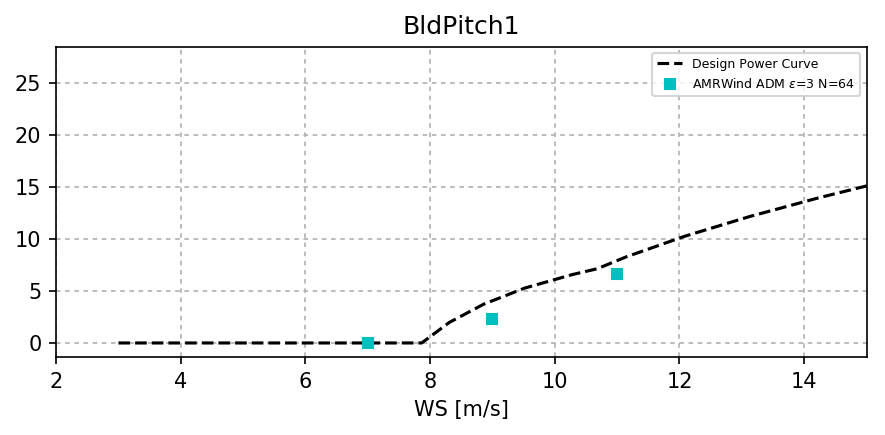

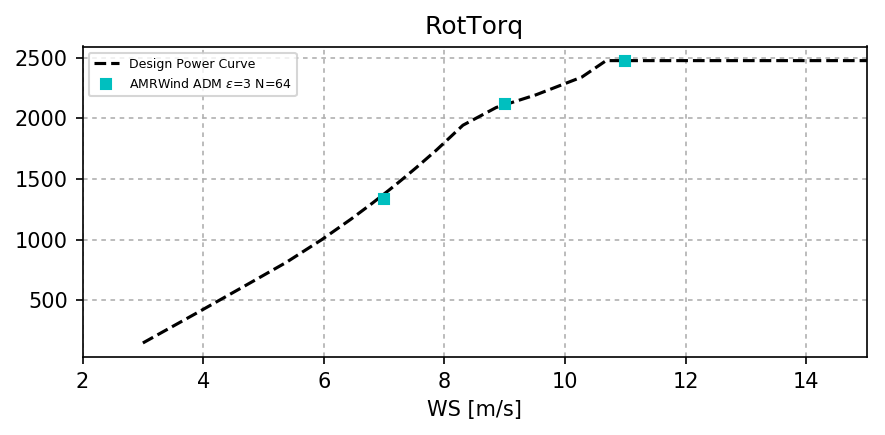

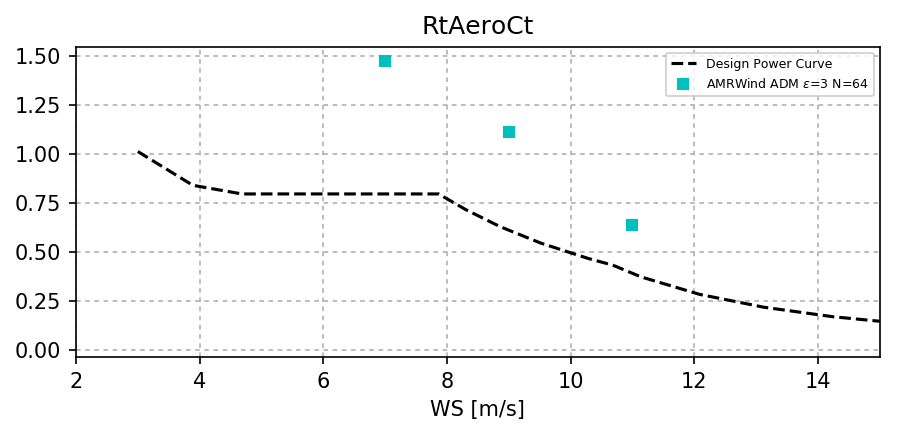

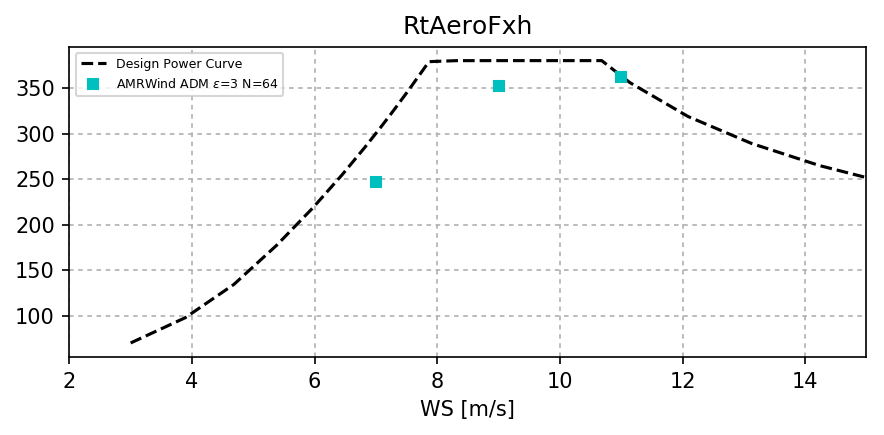

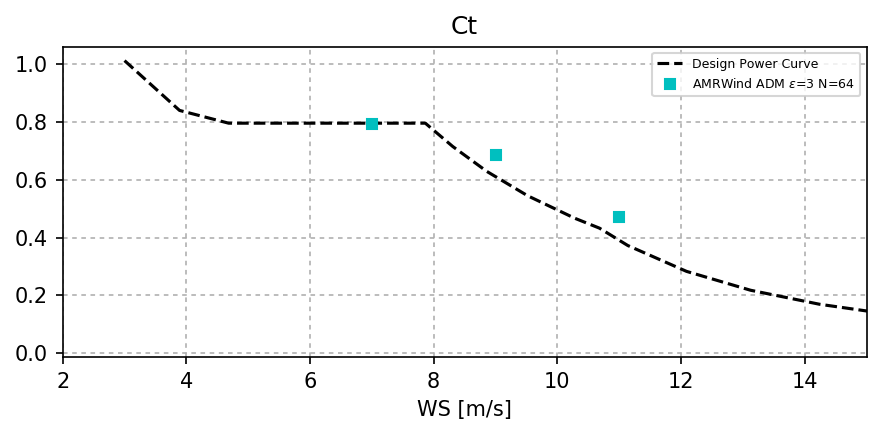

In [6]:
# Put curves to plot here
plotcurves = PC_amr 

# Plot quantities
for iq, q in enumerate(avgq):
    plt.figure(figsize=(6,3), dpi=150)
    # Plot original power curve
    plt.plot(pc['wind speed [m/s]'], pc[pcvar[iq]], 'k--', label='Design Power Curve')
    

    # Plot AMR-Wind power curve
    for p in plotcurves:
        scale=1000.0 if np.max(p[q])>10000 else 1.0
        mfc='w' if 'mfc' not in p else p['mfc']
        plt.plot(p['WS'], p[q]/scale, marker=p['ms'], mfc=mfc, mec=p['color'], linewidth=0, ms=5, label=p['tag'])
        
        
    plt.legend(fontsize=6) # loc='lower right',
    plt.xlabel('WS [m/s]')
    plt.xlim([2,15])
    plt.grid(linestyle=':')
    plt.title(q)
    plt.tight_layout()
    
# Plot real Ct
plt.figure(figsize=(6,3), dpi=150)
plt.plot(pc['wind speed [m/s]'], pc['Ct [-]'], 'k--', label='Design Power Curve')

for p in plotcurves:
    density = p['rho'] if 'rho' in p else rho
    ctx = calcCt(p, density, p['WS'], rmax)
    mfc='w' if 'mfc' not in p else p['mfc']
    plt.plot(p['WS'], ctx, marker=p['ms'], mfc=mfc, mec=p['color'], linewidth=0, ms=5, label=p['tag'])

plt.legend(fontsize=6) # loc='lower right',
plt.xlabel('WS [m/s]')
plt.xlim([2,15])
plt.grid(linestyle=':')
plt.title('Ct')
plt.tight_layout()